In [1]:
from ArticlesRep import MeanSimilarityoneindustry,MeanSimilaritytwoindustry #common function

import pandas as pd

import numpy as np

%matplotlib inline

import pickle

import visdom

from tqdm import tnrange, tqdm_notebook
from tqdm.autonotebook import tqdm
tqdm.pandas()

from time import time,sleep
from datetime import datetime

from sklearn.metrics.pairwise import cosine_similarity
# import visdom
# vis=visdom.Visdom()
# env="TagBased"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning,)
# %matplotlib inline

import re

from pprint import pprint
#coding:utf-8
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'
list_industry=["水泥","食品飲料","石化","紡織","電機機械","電器電纜","化學工業",
               "建材居家用品","造紙","鋼鐵金屬","車輛相關","科技相關","營建地產","運輸","觀光休閒娛樂",
               "金融相關","百貨通路","公用事業","控股","生技醫療保健","農林漁牧","航天軍工","能源","傳播出版","綜合",
               "傳產其他","其他","金屬礦採選",
              ]

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
from keras.layers import Dense,Lambda,Input,Dot,Add,Subtract,GaussianDropout
from keras.utils import Sequence,plot_model
from keras.models import Model,load_model
from keras import backend as K


### Denoising Autoencoder with weak supervision

In [3]:
# custommed function
def noisefunction(x):
    x_noise=K.ones_like(x)
    return K.in_train_phase(x_noise,x,1)

def tripletlossfunction(inputs):
    r01=inputs[0]
    r02=inputs[1]
    loss=K.log(1+K.exp(r01-r02))
#     x=np.array([[0],[1],[0],[1]])
#     x=K.variable(x)
    return loss

def losspassfunction(y_true,y_pred):
    return y_pred

def test(inputs):
#     x=K.dot(inputs,k.transpose(inputs))
    x=K.transpose(inputs)
    return x

In [4]:
x=Input(shape=(5,))
y=Lambda(noisefunction)(x)
model=Model(x,y)
x=np.arange(2*5).reshape((2,5))
model.predict(x)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [52]:
K.clear_session()
np.random.seed(100)
###############
# instantiate layer
# noise=Lambda(noisefunction,name="noisefunction")
# trilosslayer=Lambda(Triplet,name="trilosslayer")
# dense=Dense(units=12000,activation="sigmoid",name="Dense1")
###############

##Encoder
x=Input((20000,),name="encoder_input")
# y=Lambda(noisefunction,name="noisefunction")
y=GaussianDropout(rate=0.5,name="noise")(x)
y=Dense(units=500,activation="sigmoid",name="Dense")(y)
encoder=Model(x,y,name="encoder")

##Decoder
x=Input((500,),name="input") 
y=Dense(units=20000,activation="sigmoid",name="Dense")(x)
decoder=Model(x,y,name="decoder")

##Tripletloss
x0=Input((500,),name="anchor_input")
x1=Input((500,),name="positive_input")
x2=Input((500,),name="negative_input")
r01=Dot(axes=1,name="SimiPositive")([x0,x1])
r02=Dot(axes=1,name="SimiNegative")([x0,x2])
out=Lambda(tripletlossfunction,name="tripletlossfunction")([r01,r02])
tripletloss=Model(inputs=[x0,x1,x2],outputs=out,name="triplet")

#Build Tri-Autoencoder model
x0=Input((20000,),name="anchor_input")
x1=Input((20000,),name="positive_input")
x2=Input((20000,),name="negative_input")

h0=encoder(x0)
h1=encoder(x1)
h2=encoder(x2)

Lt=tripletloss([h0,h1,h2])

y0=decoder(h0)
y1=decoder(h1)
y2=decoder(h2)

y0=Lambda(lambda x :x ,name="anchor")(y0)
y1=Lambda(lambda x :x ,name="positive")(y1)
y2=Lambda(lambda x :x ,name="negative")(y2)

# triplet_loss

Tri_AutoEncoder=Model(inputs=[x0,x1,x2],outputs=[y0,y1,y2,Lt])
Tri_AutoEncoder.compile(optimizer="adam",
                        loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy',losspassfunction],
                        loss_weights=[1,1,1,1]
                       )

Tri_AutoEncoder.save("Tri_AutoEncoder.v01.h5")
encoder.save("encoder.v01.h5")
decoder.save("decoder.v01.h5")
plot_model(Tri_AutoEncoder,to_file="test.png")
Tri_AutoEncoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 20000)        0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 20000)        0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 20000)        0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 500)          10000500    anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

In [45]:
with open("D:3.AutoencoderForArticle/dict_small_triplet.p","rb") as f:
    dict_small_triplet=pickle.load(f)

In [9]:
# Data=np.load("D:3.AutoencoderForArticle/BOW_binary_v01.npy")

In [10]:
for k in dict_small_triplet:
    print(k,len(dict_small_triplet[k]))


生技醫療保健 340
營建地產 321
百貨通路 300
車輛相關 391
傳播出版 287


In [39]:
split=0.5
traintriplet=[]
for k in dict_small_triplet:
    trilist=dict_small_triplet[k]
    n=int(len(trilist)*split)
#     print(n)
    traintriplet+=trilist[:n]

testtriplet=[]
for k in dict_small_triplet:
    trilist=dict_small_triplet[k]
    n=int(len(trilist)*split)
#     print(len(trilist)-n)
    testtriplet+=trilist[n:]

In [40]:
class DataGenerator(Sequence):

    def __init__(self, tripletindex,Data, batch_size=32):
        self.tripletindex= np.asarray(tripletindex)
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(self.tripletindex.shape[0] / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_index = self.tripletindex[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_anchor = Data[batch_index[:,0]]
        batch_positive = Data[batch_index[:,1]]
        batch_negative = Data[batch_index[:,2]]
        tripletloss=np.zeros((batch_negative.shape[0],1))
        return [batch_anchor,batch_positive,batch_negative],[batch_anchor,batch_positive,batch_negative,tripletloss]
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        self.tripletindex=np.random.permutation(self.tripletindex)
        pass

In [53]:
# train0=np.random.randint(0,2,(4,12000))
# train1=np.random.randint(0,2,(4,12000))
# train2=np.random.randint(0,2,(4,12000))
# labels=np.ones((4,1))
traingenerator=DataGenerator(tripletindex=traintriplet,Data=Data,batch_size=500)
testgenerator=DataGenerator(tripletindex=testtriplet,Data=Data,batch_size=500)
History=Tri_AutoEncoder.fit_generator(traingenerator,epochs=100,verbose=2,validation_data=testgenerator,
                              workers=3,use_multiprocessing=False,
                              
                             )

Epoch 1/100
 - 5s - loss: 4.0284 - anchor_loss: 0.6344 - positive_loss: 0.6344 - negative_loss: 0.6351 - triplet_loss: 2.1245 - val_loss: 3.3646 - val_anchor_loss: 0.4874 - val_positive_loss: 0.4874 - val_negative_loss: 0.4880 - val_triplet_loss: 1.9018
Epoch 2/100
 - 4s - loss: 2.4100 - anchor_loss: 0.4517 - positive_loss: 0.4516 - negative_loss: 0.4498 - triplet_loss: 1.0568 - val_loss: 2.8912 - val_anchor_loss: 0.3406 - val_positive_loss: 0.3405 - val_negative_loss: 0.3422 - val_triplet_loss: 1.8680
Epoch 3/100
 - 4s - loss: 1.8511 - anchor_loss: 0.3178 - positive_loss: 0.3176 - negative_loss: 0.3136 - triplet_loss: 0.9020 - val_loss: 3.1748 - val_anchor_loss: 0.2361 - val_positive_loss: 0.2361 - val_negative_loss: 0.2386 - val_triplet_loss: 2.4639
Epoch 4/100
 - 4s - loss: 1.4366 - anchor_loss: 0.2223 - positive_loss: 0.2224 - negative_loss: 0.2164 - triplet_loss: 0.7755 - val_loss: 3.1713 - val_anchor_loss: 0.1630 - val_positive_loss: 0.1630 - val_negative_loss: 0.1659 - val_tripl

Epoch 34/100
 - 4s - loss: 0.3420 - anchor_loss: 0.0287 - positive_loss: 0.0286 - negative_loss: 0.0282 - triplet_loss: 0.2565 - val_loss: 5.7414 - val_anchor_loss: 0.0283 - val_positive_loss: 0.0283 - val_negative_loss: 0.0283 - val_triplet_loss: 5.6566
Epoch 35/100
 - 4s - loss: 0.3562 - anchor_loss: 0.0286 - positive_loss: 0.0286 - negative_loss: 0.0279 - triplet_loss: 0.2711 - val_loss: 5.7808 - val_anchor_loss: 0.0282 - val_positive_loss: 0.0282 - val_negative_loss: 0.0282 - val_triplet_loss: 5.6961
Epoch 36/100
 - 4s - loss: 0.3531 - anchor_loss: 0.0284 - positive_loss: 0.0286 - negative_loss: 0.0280 - triplet_loss: 0.2681 - val_loss: 5.8299 - val_anchor_loss: 0.0281 - val_positive_loss: 0.0281 - val_negative_loss: 0.0282 - val_triplet_loss: 5.7454
Epoch 37/100
 - 4s - loss: 0.3243 - anchor_loss: 0.0285 - positive_loss: 0.0283 - negative_loss: 0.0280 - triplet_loss: 0.2394 - val_loss: 5.8846 - val_anchor_loss: 0.0281 - val_positive_loss: 0.0281 - val_negative_loss: 0.0281 - val_t

Epoch 67/100
 - 4s - loss: 0.2179 - anchor_loss: 0.0273 - positive_loss: 0.0274 - negative_loss: 0.0269 - triplet_loss: 0.1363 - val_loss: 6.8104 - val_anchor_loss: 0.0272 - val_positive_loss: 0.0272 - val_negative_loss: 0.0271 - val_triplet_loss: 6.7288
Epoch 68/100
 - 4s - loss: 0.2499 - anchor_loss: 0.0271 - positive_loss: 0.0273 - negative_loss: 0.0271 - triplet_loss: 0.1684 - val_loss: 6.8397 - val_anchor_loss: 0.0272 - val_positive_loss: 0.0272 - val_negative_loss: 0.0271 - val_triplet_loss: 6.7582
Epoch 69/100
 - 4s - loss: 0.2334 - anchor_loss: 0.0272 - positive_loss: 0.0273 - negative_loss: 0.0270 - triplet_loss: 0.1519 - val_loss: 6.8760 - val_anchor_loss: 0.0272 - val_positive_loss: 0.0272 - val_negative_loss: 0.0271 - val_triplet_loss: 6.7946
Epoch 70/100
 - 4s - loss: 0.2469 - anchor_loss: 0.0272 - positive_loss: 0.0272 - negative_loss: 0.0269 - triplet_loss: 0.1657 - val_loss: 6.9046 - val_anchor_loss: 0.0272 - val_positive_loss: 0.0272 - val_negative_loss: 0.0270 - val_t

Epoch 100/100
 - 4s - loss: 0.1881 - anchor_loss: 0.0266 - positive_loss: 0.0265 - negative_loss: 0.0267 - triplet_loss: 0.1083 - val_loss: 7.6502 - val_anchor_loss: 0.0269 - val_positive_loss: 0.0269 - val_negative_loss: 0.0266 - val_triplet_loss: 7.5699


In [91]:
# Tri_AutoEncoder.save("Tri_AutoEncoder_trained.v01.h5")
# encoder.save("encoder_trained.v01.h5")
# decoder.save("decoder_trained.v01.h5")

In [55]:
df=pd.DataFrame(History.history)

In [ ]:
# df.to_hdf("history.h5",key="data")

In [2]:
df=pd.read_hdf("history.h5")

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


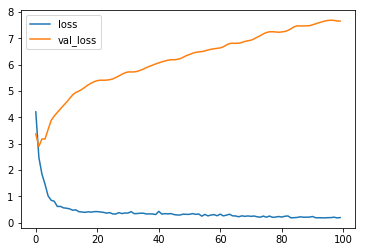

In [4]:
df[["loss","val_loss"]].plot()

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


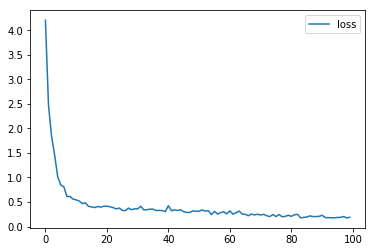

In [5]:
df[["loss"]].plot()

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


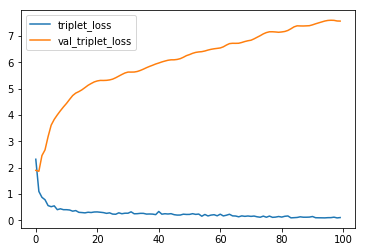

In [6]:
df[["triplet_loss","val_triplet_loss"]].plot()

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


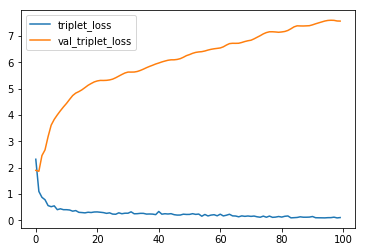

In [7]:
df[["triplet_loss","val_triplet_loss"]].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000228D565D898>,
      dtype=object)

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


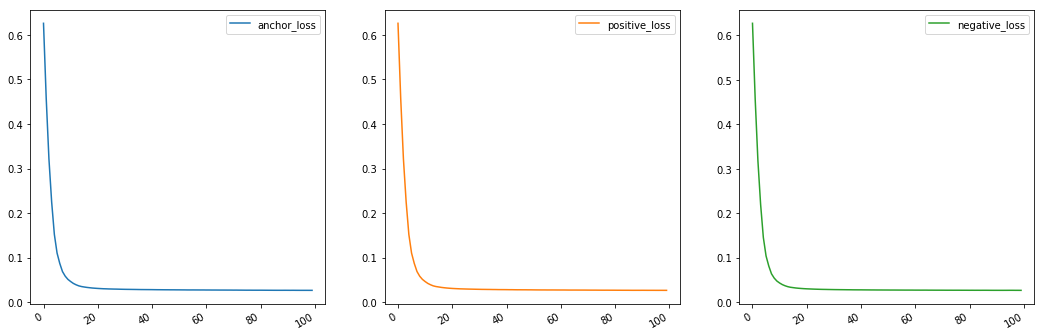

In [8]:
df[["anchor_loss","positive_loss","negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000228D571EC18>,
      dtype=object)

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


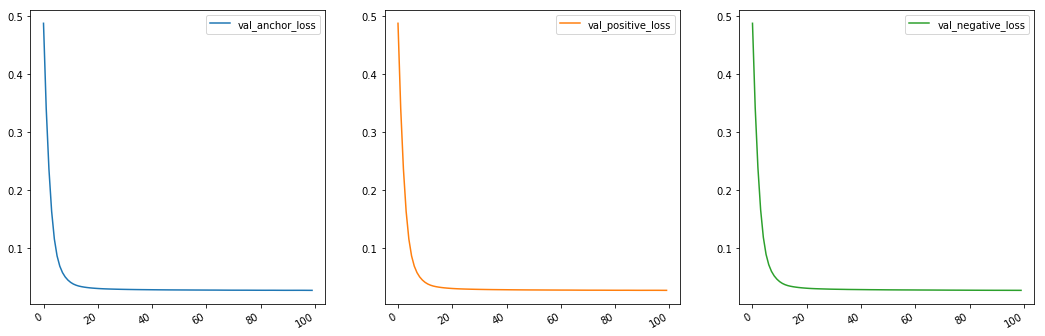

In [9]:
df[["val_anchor_loss","val_positive_loss","val_negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

In [95]:
df.to_hdf("history.h5",key="data")

In [99]:
pd.read_hdf("history.h5")

,anchor_loss,loss,negative_loss,positive_loss,triplet_loss,val_anchor_loss,val_loss,val_negative_loss,val_positive_loss,val_triplet_loss
0,0.626091,4.203110,0.626969,0.626107,2.323943,0.487383,3.364572,0.488022,0.487379,1.901787
1,0.457633,2.472969,0.455777,0.457453,1.102107,0.340556,2.891246,0.342178,0.340547,1.867964
2,0.321888,1.839836,0.317772,0.321770,0.878406,0.236143,3.174835,0.238622,0.236128,2.463942
3,0.225302,1.456694,0.219377,0.225394,0.786622,0.162983,3.171282,0.165863,0.162959,2.679477
4,0.152149,1.013880,0.145457,0.152089,0.564185,0.115368,3.532528,0.118157,0.115338,3.183665
5,0.110259,0.846982,0.103968,0.110235,0.522521,0.086314,3.879188,0.088801,0.086287,3.617786
6,0.086898,0.809654,0.081400,0.087003,0.554353,0.068658,4.046678,0.070824,0.068636,3.838559
7,0.068694,0.610842,0.063872,0.068868,0.409408,0.057501,4.182720,0.059382,0.057483,4.008354
8,0.058419,0.614146,0.054212,0.058350,0.443165,0.049970,4.316643,0.051578,0.049954,4.165141
9,0.051215,0.559020,0.047525,0.051248,0.409033,0.044590,4.446387,0.045932,0.044576,4.311290
